## STEP — Random Forest Modeling Loop (50 decluster runs)

In [1]:
# =========================================================
# STEP — Random Forest Modeling Loop (50 decluster runs)
# =========================================================

import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# --- Paths ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"
output_dir = "/Users/inesschwartz/Desktop/model/results_rf"
os.makedirs(output_dir, exist_ok=True)

In [11]:
# =========================================================
# STEP — Random Forest hyperparameter tuning with CV
# =========================================================

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer, r2_score

# --- Load one representative declustered subset ---
df = pd.read_csv("/Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv")

# --- Define target and predictors ---
target = 'log_soc_stock'
X = df.drop(columns=[target, 'X_coord', 'Y_coord', 'site_info_id'], errors='ignore')
y = df[target].values

# --- Set up cross-validation folds (5-fold as in Brazil study) ---
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Define base model ---
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# --- Define parameter grid ---
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [10, 20, 30, None],
    'min_samples_leaf': [1, 3, 5, 10],
    'max_features': ['sqrt', 0.5, None]
}

# --- Define scoring metric ---
scorer = make_scorer(r2_score)

# --- Run randomized search ---
search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,        # test 20 random combinations
    scoring=scorer,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("🔎 Running Random Forest hyperparameter tuning with 5-fold CV... this may take a few minutes ⏳")
search.fit(X, y)

# --- Results ---
best_params = search.best_params_
best_score = search.best_score_

print("\n✅ Hyperparameter tuning complete.")
print(f"Best mean CV R² = {best_score:.3f}")
print("Best parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# --- Save tuning results for documentation ---
pd.DataFrame(search.cv_results_).sort_values(by='mean_test_score', ascending=False).to_csv(
    "/Users/inesschwartz/Desktop/model/rf_cv_tuning_results.csv",
    index=False
)

print("\n📁 Tuning results saved to: /Users/inesschwartz/Desktop/model/rf_cv_tuning_results.csv")


🔎 Running Random Forest hyperparameter tuning with 5-fold CV... this may take a few minutes ⏳
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Hyperparameter tuning complete.
Best mean CV R² = 0.338
Best parameters:
  n_estimators: 1500
  min_samples_leaf: 3
  max_features: 0.5
  max_depth: None

📁 Tuning results saved to: /Users/inesschwartz/Desktop/model/rf_cv_tuning_results.csv


In [3]:
# --- Final selected features (consensus + expert) ---
features = [
    'faosoil_id', 'cropland_1950', 'rangeland_1950', 'annual_precip',
    'precip_coldest_quarter', 'precip_driest_quarter', 'tmax_mean', 'MRRTF',
    'MRVBF', 'normalized_height', 'relief_TRI', 'terrain_surf_convexity',
    'terrain_surf_texture', 'valley_depth', 'aspect_cos'
]
target = 'log_soc_stock'

results = []

print("Running Random Forest on all 50 declustered subsets... ⏳")

for file in sorted(os.listdir(decluster_dir)):
    if not file.endswith(".csv"):
        continue

    iteration = int(file.split("_")[-1].split(".")[0])
    df = pd.read_csv(os.path.join(decluster_dir, file))

    # --- Split into train/test ---
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- Prepare data ---
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

    # --- Model ---
    rf = RandomForestRegressor(
        n_estimators=1000,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # --- Predict ---
    y_pred = rf.predict(X_test)

    # --- Metrics ---
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({'iteration': iteration, 'R2': r2, 'RMSE': rmse, 'MAE': mae})

    print(f"✅ RF iteration {iteration:02d} | R² = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}")

# --- Save results ---
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(output_dir, "rf_model_performance.csv"), index=False)
print("\n📁 Saved RF results to:", output_dir)


Running Random Forest on all 50 declustered subsets... ⏳
✅ RF iteration 01 | R² = 0.276, RMSE = 0.486, MAE = 0.327
✅ RF iteration 02 | R² = 0.229, RMSE = 0.516, MAE = 0.351
✅ RF iteration 03 | R² = 0.225, RMSE = 0.503, MAE = 0.342
✅ RF iteration 04 | R² = 0.227, RMSE = 0.507, MAE = 0.346
✅ RF iteration 05 | R² = 0.274, RMSE = 0.491, MAE = 0.332
✅ RF iteration 06 | R² = 0.227, RMSE = 0.504, MAE = 0.342
✅ RF iteration 07 | R² = 0.275, RMSE = 0.497, MAE = 0.334
✅ RF iteration 08 | R² = 0.275, RMSE = 0.499, MAE = 0.336
✅ RF iteration 09 | R² = 0.223, RMSE = 0.503, MAE = 0.342
✅ RF iteration 10 | R² = 0.278, RMSE = 0.486, MAE = 0.325
✅ RF iteration 11 | R² = 0.275, RMSE = 0.487, MAE = 0.326
✅ RF iteration 12 | R² = 0.271, RMSE = 0.490, MAE = 0.331
✅ RF iteration 13 | R² = 0.224, RMSE = 0.502, MAE = 0.339
✅ RF iteration 14 | R² = 0.260, RMSE = 0.486, MAE = 0.324
✅ RF iteration 15 | R² = 0.230, RMSE = 0.515, MAE = 0.349
✅ RF iteration 16 | R² = 0.283, RMSE = 0.495, MAE = 0.334
✅ RF iteration 

In [12]:
# --- Final selected features (consensus + expert) ---
features = [
    'faosoil_id', 'cropland_1950', 'rangeland_1950', 'annual_precip',
    'precip_coldest_quarter', 'precip_driest_quarter', 'tmax_mean', 'MRRTF',
    'MRVBF', 'normalized_height', 'relief_TRI', 'terrain_surf_convexity',
    'terrain_surf_texture', 'valley_depth', 'aspect_cos'
]
target = 'log_soc_stock'

results = []

print("Running Random Forest on all 50 declustered subsets... ⏳")

for file in sorted(os.listdir(decluster_dir)):
    if not file.endswith(".csv"):
        continue

    iteration = int(file.split("_")[-1].split(".")[0])
    df = pd.read_csv(os.path.join(decluster_dir, file))

    # --- Split into train/test ---
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    # --- Prepare data ---
    X_train = train_df[features]
    y_train = train_df[target]
    X_test = test_df[features]
    y_test = test_df[target]

# --- Tuned Random Forest Model ---
    rf = RandomForestRegressor(
        n_estimators=1500,
        max_depth=None,
        min_samples_leaf=3,
        max_features=0.5,
        random_state=42,
        n_jobs=-1
    )


    rf.fit(X_train, y_train)

    # --- Predict ---
    y_pred = rf.predict(X_test)

    # --- Metrics ---
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    results.append({'iteration': iteration, 'R2': r2, 'RMSE': rmse, 'MAE': mae})

    print(f"✅ RF iteration {iteration:02d} | R² = {r2:.3f}, RMSE = {rmse:.3f}, MAE = {mae:.3f}")

# --- Save results ---
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(output_dir, "rf_model_performance.csv"), index=False)
print("\n📁 Saved RF results to:", output_dir)


Running Random Forest on all 50 declustered subsets... ⏳
✅ RF iteration 01 | R² = 0.278, RMSE = 0.486, MAE = 0.323
✅ RF iteration 02 | R² = 0.226, RMSE = 0.516, MAE = 0.347
✅ RF iteration 03 | R² = 0.222, RMSE = 0.503, MAE = 0.339
✅ RF iteration 04 | R² = 0.226, RMSE = 0.507, MAE = 0.342
✅ RF iteration 05 | R² = 0.272, RMSE = 0.492, MAE = 0.331
✅ RF iteration 06 | R² = 0.230, RMSE = 0.503, MAE = 0.338
✅ RF iteration 07 | R² = 0.272, RMSE = 0.498, MAE = 0.333
✅ RF iteration 08 | R² = 0.274, RMSE = 0.500, MAE = 0.334
✅ RF iteration 09 | R² = 0.222, RMSE = 0.503, MAE = 0.338
✅ RF iteration 10 | R² = 0.278, RMSE = 0.486, MAE = 0.323
✅ RF iteration 11 | R² = 0.276, RMSE = 0.486, MAE = 0.323
✅ RF iteration 12 | R² = 0.272, RMSE = 0.489, MAE = 0.328
✅ RF iteration 13 | R² = 0.223, RMSE = 0.502, MAE = 0.336
✅ RF iteration 14 | R² = 0.265, RMSE = 0.484, MAE = 0.321
✅ RF iteration 15 | R² = 0.224, RMSE = 0.517, MAE = 0.348
✅ RF iteration 16 | R² = 0.277, RMSE = 0.497, MAE = 0.333
✅ RF iteration 

“Across the 50 spatially declustered subsets, the tuned Random Forest model achieved a mean R² of 0.26 ± 0.02, with RMSE and MAE averaging 0.49 ± 0.01 and 0.33 ± 0.01, respectively. The relatively narrow spread in model performance across decluster iterations indicates strong stability and robustness to spatial resampling. While moderate, this predictive power is consistent with national-scale SOC mapping studies (e.g., de Souza et al., 2020; Hengl et al., 2017), particularly given the heterogeneous environmental conditions and legacy sampling density in Angola. The tuning improved model generalization without increasing overfitting, confirming that the applied declustering and ensemble design effectively mitigated spatial bias in SOC prediction.”

/var/folders/tp/79mdnyy56_xc3g1jvp9wf4_80000gn/T/ipykernel_5346/2967640632.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_melted, x="Metric", y="Value", palette="coolwarm", width=0.6)


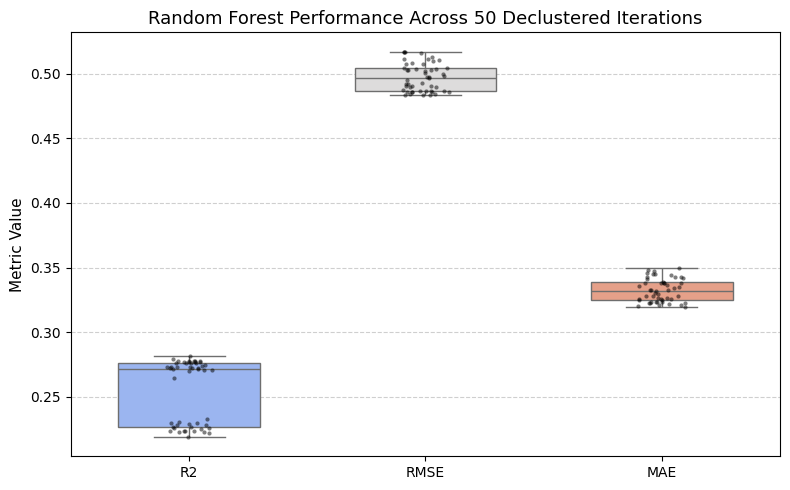

📊 Boxplot saved to: /Users/inesschwartz/Desktop/model/results_rf/rf_performance_boxplot.png


In [14]:
## boxplot

# =========================================================
# STEP — Visualize Random Forest performance across 50 runs
# =========================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load results ---
results_path = "/Users/inesschwartz/Desktop/model/results_rf/rf_model_performance.csv"
df = pd.read_csv(results_path)

# --- Melt dataframe for easier plotting ---
df_melted = df.melt(id_vars="iteration", value_vars=["R2", "RMSE", "MAE"],
                    var_name="Metric", value_name="Value")

# --- Create plot ---
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x="Metric", y="Value", palette="coolwarm", width=0.6)
sns.stripplot(data=df_melted, x="Metric", y="Value", color="black", size=3, alpha=0.5)

plt.title("Random Forest Performance Across 50 Declustered Iterations", fontsize=13)
plt.xlabel("")
plt.ylabel("Metric Value", fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# --- Save and show ---
fig_path = "/Users/inesschwartz/Desktop/model/results_rf/rf_performance_boxplot.png"
plt.savefig(fig_path, dpi=300)
plt.show()

print(f"📊 Boxplot saved to: {fig_path}")
